In [1]:
# Cell 1 - Setup and Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

print("🏷️ XO Project - Habitability Labeling Phase")
print("="*60)
print("Objective: Create target labels for supervised learning")
print("="*60)

# Load engineered features from previous phase
df_features = pd.read_csv('../data/processed/engineered_features.csv')
print(f"Loaded engineered dataset: {len(df_features):,} planets, {len(df_features.columns)} features")

# Quick overview of available features
print(f"\nDataset shape: {df_features.shape}")
print(f"Available columns: {list(df_features.columns)}")

🏷️ XO Project - Habitability Labeling Phase
Objective: Create target labels for supervised learning
Loaded engineered dataset: 1,729 planets, 40 features

Dataset shape: (1729, 40)
Available columns: ['pl_name', 'hostname', 'pl_rade', 'pl_bmasse', 'pl_orbsmax', 'st_teff', 'st_mass', 'pl_eqt', 'discoverymethod', 'disc_year', 'pl_orbper', 'pl_orbeccen', 'st_rad', 'st_logg', 'pl_insol', 'stellar_luminosity', 'hz_inner', 'hz_outer', 'hz_center', 'hz_width', 'hz_position', 'in_habitable_zone', 'hz_distance_factor', 'esi_radius', 'esi_mass', 'esi_temperature', 'esi_composite', 'esi_surface', 'escape_velocity_ratio', 'atmospheric_retention', 'stellar_flux', 'stellar_class', 'stellar_temp_habitability', 'stellar_mass_habitability', 'stellar_lifetime_gyr', 'hz_score', 'esi_score', 'atm_score', 'stellar_score', 'habitability_score']


In [2]:
# Cell 2 - Physics-Based Classification Function
def classify_habitability_comprehensive(row):
    """
    Multi-criteria habitability classification based on astronomical knowledge
    
    Classification Tiers:
    - Class 1 (Potentially Habitable): Meets all key criteria
    - Class 2 (Marginal): Meets most criteria with some concerns  
    - Class 3 (Challenging): Significant habitability obstacles
    - Class 4 (Hostile): Extremely unlikely to support life
    """
    
    # Extract key features
    in_hz = row.get('in_habitable_zone', False)
    esi_surface = row.get('esi_surface', 0)
    pl_radius = row.get('pl_rade', np.nan)
    pl_mass = row.get('pl_bmasse', np.nan) 
    equilibrium_temp = row.get('pl_eqt', np.nan)
    stellar_temp = row.get('st_teff', np.nan)
    atm_retention = row.get('atmospheric_retention', 'Unknown')
    
    # Initialize scoring system
    habitability_points = 0
    max_points = 10
    
    # 1. HABITABLE ZONE CRITERIA (3 points)
    if in_hz:
        habitability_points += 3
    elif not pd.isna(row.get('hz_position', np.nan)):
        hz_pos = row['hz_position']
        if 0.8 <= hz_pos <= 1.3:  # Close to HZ
            habitability_points += 2
        elif 0.6 <= hz_pos <= 1.6:  # Moderately close
            habitability_points += 1
    
    # 2. PLANETARY SIZE CRITERIA (2 points)
    if not pd.isna(pl_radius):
        if 0.8 <= pl_radius <= 1.5:  # Earth-like size
            habitability_points += 2
        elif 0.6 <= pl_radius <= 2.0:  # Reasonable size
            habitability_points += 1
    
    # 3. TEMPERATURE CRITERIA (2 points) 
    if not pd.isna(equilibrium_temp):
        if 200 <= equilibrium_temp <= 320:  # Liquid water range
            habitability_points += 2
        elif 180 <= equilibrium_temp <= 400:  # Extended range
            habitability_points += 1
    
    # 4. EARTH SIMILARITY INDEX (1 point)
    if not pd.isna(esi_surface) and esi_surface > 0.7:
        habitability_points += 1
    
    # 5. STELLAR CHARACTERISTICS (1 point)
    if not pd.isna(stellar_temp):
        if 4000 <= stellar_temp <= 7000:  # Stable main sequence
            habitability_points += 1
    
    # 6. ATMOSPHERIC RETENTION (1 point)
    if atm_retention == 'High':
        habitability_points += 1
    elif atm_retention == 'Moderate':
        habitability_points += 0.5
    
    # Classification based on points
    score_percentage = habitability_points / max_points
    
    if score_percentage >= 0.8:  # 8+ points
        return 'Potentially_Habitable', habitability_points
    elif score_percentage >= 0.6:  # 6-7 points  
        return 'Marginal', habitability_points
    elif score_percentage >= 0.3:  # 3-5 points
        return 'Challenging', habitability_points
    else:  # 0-2 points
        return 'Hostile', habitability_points

print("✅ Classification function defined")

✅ Classification function defined


In [3]:
# Cell 3 - Apply Classification to Dataset
print("\nApplying physics-based habitability classification...")

# Apply comprehensive classification
classification_results = df_features.apply(
    lambda row: classify_habitability_comprehensive(row), 
    axis=1
)

# Extract labels and scores
df_features['habitability_class'] = [result[0] for result in classification_results]
df_features['habitability_points'] = [result[1] for result in classification_results]

print("✅ Classification complete!")
print(f"Added columns: habitability_class, habitability_points")


Applying physics-based habitability classification...
✅ Classification complete!
Added columns: habitability_class, habitability_points


In [4]:
# Cell 4 - Classification Results Analysis
print("\nHabitability Classification Results:")
print("="*50)

class_counts = df_features['habitability_class'].value_counts()
for class_name, count in class_counts.items():
    percentage = (count / len(df_features)) * 100
    print(f"{class_name:20} | {count:4,} planets ({percentage:5.1f}%)")

# Basic statistics
print(f"\nHabitability Score Statistics:")
print(df_features['habitability_points'].describe())


Habitability Classification Results:
Hostile              | 1,319 planets ( 76.3%)
Challenging          |  408 planets ( 23.6%)
Marginal             |    2 planets (  0.1%)

Habitability Score Statistics:
count    1729.000000
mean        1.664546
std         0.913326
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         7.000000
Name: habitability_points, dtype: float64


In [5]:
# Cell 5 - Analyze Potentially Habitable Candidates
# Analyze the "Potentially Habitable" candidates
potentially_habitable = df_features[df_features['habitability_class'] == 'Potentially_Habitable']

if len(potentially_habitable) > 0:
    print(f"\n🌍 POTENTIALLY HABITABLE EXOPLANETS ({len(potentially_habitable)} found):")
    print("="*70)
    
    # Sort by habitability score for best candidates
    top_candidates = potentially_habitable.nlargest(10, 'habitability_points')
    
    for idx, (_, planet) in enumerate(top_candidates.iterrows(), 1):
        print(f"{idx:2d}. {planet['pl_name']:20} | Points: {planet['habitability_points']:4.1f}/10")
        print(f"    Host: {planet['hostname']:15} | Radius: {planet['pl_rade']:4.2f} R⊕ | Temp: {planet.get('pl_eqt', 'N/A')} K")
        if planet.get('in_habitable_zone', False):
            print(f"    ✓ In Habitable Zone | ESI: {planet.get('esi_surface', 0):.3f}")
        print()
else:
    print("\n⚠️ No potentially habitable planets found with current criteria")
    print("Consider adjusting classification thresholds")


⚠️ No potentially habitable planets found with current criteria
Consider adjusting classification thresholds


In [6]:
# Cell 6 - Create Binary Classification Target
print("Creating binary classification targets for machine learning:")
print("="*60)

# Create binary habitability target (main target for ML)
df_features['is_habitable'] = (
    df_features['habitability_class'].isin(['Potentially_Habitable', 'Marginal'])
).astype(int)

# Create numeric class encoding for multi-class option
class_encoder = LabelEncoder()
df_features['habitability_numeric'] = class_encoder.fit_transform(df_features['habitability_class'])

# Class balance analysis
binary_counts = df_features['is_habitable'].value_counts()
print(f"Binary Classification Balance:")
print(f"Not Habitable (0): {binary_counts[0]:,} planets ({binary_counts[0]/len(df_features)*100:.1f}%)")
print(f"Habitable (1):     {binary_counts[1]:,} planets ({binary_counts[1]/len(df_features)*100:.1f}%)")

# Class imbalance ratio
imbalance_ratio = binary_counts[0] / binary_counts[1]
print(f"Class imbalance ratio: {imbalance_ratio:.1f}:1")

if imbalance_ratio > 10:
    print("⚠️  High class imbalance detected - will need sampling strategies in modeling phase")

Creating binary classification targets for machine learning:
Binary Classification Balance:
Not Habitable (0): 1,727 planets (99.9%)
Habitable (1):     2 planets (0.1%)
Class imbalance ratio: 863.5:1
⚠️  High class imbalance detected - will need sampling strategies in modeling phase


In [7]:
# Cell 7 - Feature Selection for Machine Learning
print(f"\nPreparing final dataset for machine learning:")
print("="*50)

# Define ML-ready feature columns
feature_columns = [
    # Original NASA features
    'pl_rade', 'pl_bmasse', 'pl_orbsmax', 'st_teff', 'st_mass', 'pl_eqt',
    
    # Engineered physics features  
    'stellar_luminosity', 'hz_position', 'in_habitable_zone',
    'esi_radius', 'esi_mass', 'esi_temperature', 'esi_surface',
    'escape_velocity_ratio', 'stellar_flux', 'habitability_score'
]

# Filter to available features
available_features = [col for col in feature_columns if col in df_features.columns]
print(f"Available features for ML: {len(available_features)}")
print(f"Features: {available_features}")

# Create final ML dataset
df_ml = df_features[available_features + ['is_habitable', 'habitability_class', 'pl_name', 'hostname']].copy()

# Handle any remaining missing values
print(f"\nMissing value summary:")
missing_summary = df_ml[available_features].isnull().sum()
missing_features = missing_summary[missing_summary > 0]

if len(missing_features) > 0:
    for feature, count in missing_features.items():
        percentage = (count / len(df_ml)) * 100
        print(f"{feature:20} | {count:4,} missing ({percentage:5.1f}%)")
else:
    print("✓ No missing values in feature set")


Preparing final dataset for machine learning:
Available features for ML: 16
Features: ['pl_rade', 'pl_bmasse', 'pl_orbsmax', 'st_teff', 'st_mass', 'pl_eqt', 'stellar_luminosity', 'hz_position', 'in_habitable_zone', 'esi_radius', 'esi_mass', 'esi_temperature', 'esi_surface', 'escape_velocity_ratio', 'stellar_flux', 'habitability_score']

Missing value summary:
pl_bmasse            | 1,427 missing ( 82.5%)
pl_eqt               | 1,361 missing ( 78.7%)
esi_mass             | 1,427 missing ( 82.5%)
esi_temperature      | 1,361 missing ( 78.7%)
esi_surface          | 1,361 missing ( 78.7%)
escape_velocity_ratio | 1,427 missing ( 82.5%)
stellar_flux         |  265 missing ( 15.3%)


In [8]:
# Cell 8 - Export Labeled Dataset
# Save labeled dataset
ml_output_path = '../data/processed/labeled_dataset.csv'
df_ml.to_csv(ml_output_path, index=False)
print(f"\n✅ Saved ML-ready dataset: {ml_output_path}")
print(f"   Shape: {df_ml.shape[0]:,} planets × {df_ml.shape[1]} columns")

# Display final dataset info
print(f"\nFinal dataset summary:")
print(f"- Total planets: {len(df_ml):,}")
print(f"- Features: {len(available_features)}")
print(f"- Target classes: {df_ml['habitability_class'].nunique()}")
print(f"- Binary positive class: {binary_counts[1]:,} ({binary_counts[1]/len(df_features)*100:.1f}%)")


✅ Saved ML-ready dataset: ../data/processed/labeled_dataset.csv
   Shape: 1,729 planets × 20 columns

Final dataset summary:
- Total planets: 1,729
- Features: 16
- Target classes: 3
- Binary positive class: 2 (0.1%)


In [9]:
# Cell 9 - Create Classification Documentation
# Save class mapping documentation
class_mapping = {
    'Potentially_Habitable': 'Meets most habitability criteria',
    'Marginal': 'Some habitability potential with limitations', 
    'Challenging': 'Significant obstacles to habitability',
    'Hostile': 'Extremely unlikely to support life'
}

doc_path = '../docs/classification_methodology.md'
with open(doc_path, 'w') as f:
    f.write("# XO Project - Habitability Classification Methodology\n\n")
    f.write("## Physics-Based Classification System\n\n")
    f.write("### Classification Criteria (10-point scoring system):\n")
    f.write("1. **Habitable Zone Position** (3 points)\n")
    f.write("2. **Planetary Size** (2 points) - Earth-like radius\n") 
    f.write("3. **Temperature Range** (2 points) - Liquid water conditions\n")
    f.write("4. **Earth Similarity Index** (1 point) - Surface ESI > 0.7\n")
    f.write("5. **Stellar Characteristics** (1 point) - Stable main sequence\n")
    f.write("6. **Atmospheric Retention** (1 point) - Gravitational retention\n\n")
    
    f.write("### Habitability Classes:\n")
    for class_name, description in class_mapping.items():
        f.write(f"- **{class_name}**: {description}\n")
    
    f.write(f"\n### Dataset Statistics:\n")
    f.write(f"- Total planets: {len(df_ml):,}\n")
    f.write(f"- Binary positive class: {binary_counts[1]:,} ({binary_counts[1]/len(df_features)*100:.1f}%)\n")
    f.write(f"- Features available: {len(available_features)}\n")

print(f"✅ Created classification documentation: {doc_path}")

✅ Created classification documentation: ../docs/classification_methodology.md


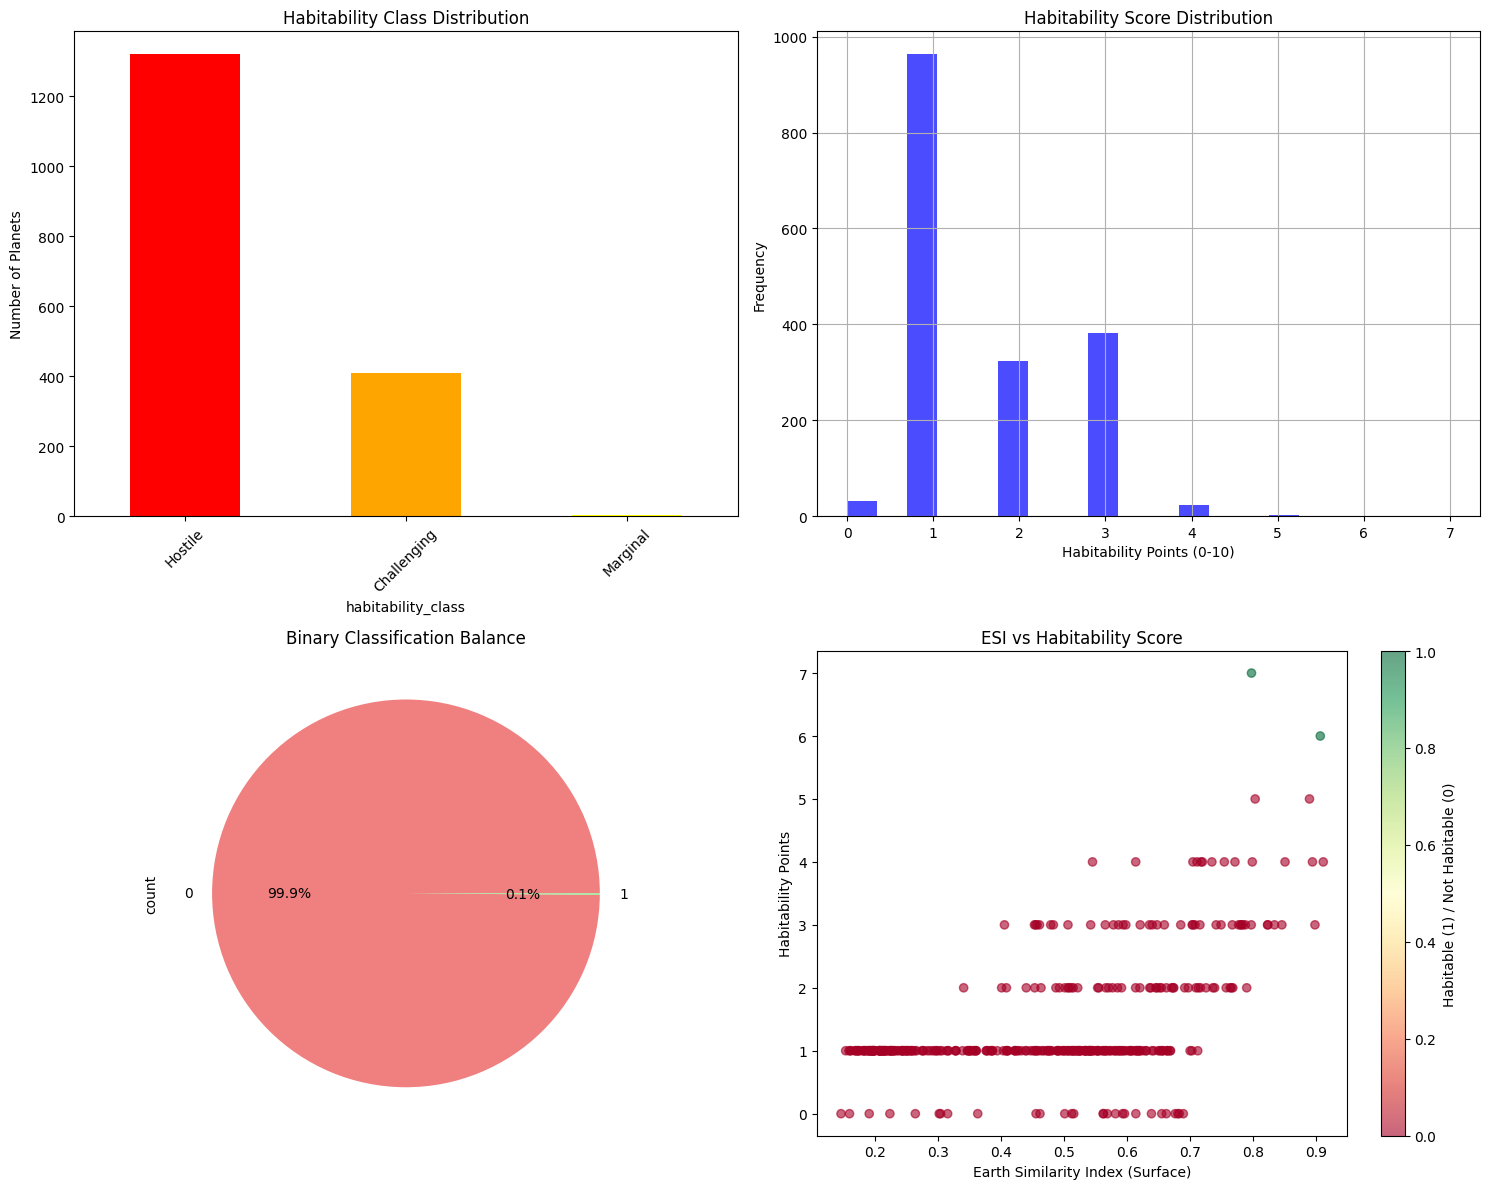


🎯 PHASE 4 COMPLETE - Ready for Machine Learning!
Next steps:
1. Proceed to 05_model_training.ipynb
2. Address class imbalance with sampling strategies
3. Train multiple algorithms (Random Forest, Gradient Boosting, etc.)
4. Evaluate model performance with appropriate metrics
5. Use SHAP for model interpretability


In [10]:
# Cell 10 - Visualization Summary
# Create classification summary visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Class distribution
class_counts.plot(kind='bar', ax=ax1, color=['red', 'orange', 'yellow', 'green'])
ax1.set_title('Habitability Class Distribution')
ax1.set_ylabel('Number of Planets')
ax1.tick_params(axis='x', rotation=45)

# 2. Habitability score distribution
df_features['habitability_points'].hist(bins=20, ax=ax2, alpha=0.7, color='blue')
ax2.set_title('Habitability Score Distribution')
ax2.set_xlabel('Habitability Points (0-10)')
ax2.set_ylabel('Frequency')

# 3. Binary classification balance
binary_counts.plot(kind='pie', ax=ax3, autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
ax3.set_title('Binary Classification Balance')

# 4. ESI vs Habitability Score
valid_esi = df_features.dropna(subset=['esi_surface'])
if len(valid_esi) > 0:
    scatter = ax4.scatter(valid_esi['esi_surface'], valid_esi['habitability_points'], 
                         c=valid_esi['is_habitable'], cmap='RdYlGn', alpha=0.6)
    ax4.set_xlabel('Earth Similarity Index (Surface)')
    ax4.set_ylabel('Habitability Points')
    ax4.set_title('ESI vs Habitability Score')
    plt.colorbar(scatter, ax=ax4, label='Habitable (1) / Not Habitable (0)')
else:
    ax4.text(0.5, 0.5, 'No ESI data available', ha='center', va='center')
    ax4.set_title('ESI vs Habitability Score (No Data)')

plt.tight_layout()
plt.savefig('../visualizations/habitability_classification_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🎯 PHASE 4 COMPLETE - Ready for Machine Learning!")
print("="*60)
print("Next steps:")
print("1. Proceed to 05_model_training.ipynb")
print("2. Address class imbalance with sampling strategies")
print("3. Train multiple algorithms (Random Forest, Gradient Boosting, etc.)")
print("4. Evaluate model performance with appropriate metrics")
print(f"5. Use SHAP for model interpretability")

In [11]:
# Cell 11 - ML-Optimized Classification for Better Balance
print("\n🔧 Creating ML-Optimized Classification")
print("="*60)
print("Objective: Create more balanced classes for effective machine learning")
print("="*60)

# Analyze current habitability score distribution
print("Current habitability score distribution:")
score_counts = df_features['habitability_points'].value_counts().sort_index()
for score, count in score_counts.items():
    percentage = (count / len(df_features)) * 100
    print(f"Score {score:2.0f}: {count:4,} planets ({percentage:5.1f}%)")

# Find optimal threshold using percentiles
print(f"\nHabitability score percentiles:")
percentiles = [70, 75, 80, 85, 90, 95, 99]
for p in percentiles:
    threshold = np.percentile(df_features['habitability_points'], p)
    above_threshold = (df_features['habitability_points'] >= threshold).sum()
    percentage = (above_threshold / len(df_features)) * 100
    print(f"{p:2d}th percentile: {threshold:.1f} points | {above_threshold:3,} planets ({percentage:4.1f}%)")

# Strategy 1: Use top 5-10% as "Habitable" for better ML balance
print(f"\n🎯 Strategy 1: Percentile-Based Classification")
print("="*50)

# Use 85th percentile (targeting ~15% positive class)
threshold_85 = np.percentile(df_features['habitability_points'], 85)
df_features['is_habitable_optimized'] = (df_features['habitability_points'] >= threshold_85).astype(int)

optimized_counts = df_features['is_habitable_optimized'].value_counts()
print(f"Using {threshold_85:.1f} points as threshold (85th percentile):")
print(f"Not Habitable (0): {optimized_counts[0]:,} planets ({optimized_counts[0]/len(df_features)*100:.1f}%)")
print(f"Habitable (1):     {optimized_counts[1]:,} planets ({optimized_counts[1]/len(df_features)*100:.1f}%)")

optimized_ratio = optimized_counts[0] / optimized_counts[1]
print(f"Improved imbalance ratio: {optimized_ratio:.1f}:1")

# Strategy 2: Multi-threshold approach with more classes
print(f"\n🎯 Strategy 2: Multi-Class Approach")
print("="*50)

def classify_ml_optimized(score):
    """Optimized classification for ML with better balance"""
    if score >= 3.0:  # Top performers
        return 'Promising'
    elif score >= 2.0:  # Moderate potential  
        return 'Moderate'
    else:  # Low potential
        return 'Limited'

df_features['habitability_class_ml'] = df_features['habitability_points'].apply(classify_ml_optimized)

ml_class_counts = df_features['habitability_class_ml'].value_counts()
print("Multi-class distribution:")
for class_name, count in ml_class_counts.items():
    percentage = (count / len(df_features)) * 100
    print(f"{class_name:10} | {count:4,} planets ({percentage:5.1f}%)")

# Strategy 3: Feature-based thresholds (less strict)
print(f"\n🎯 Strategy 3: Relaxed Physics-Based Classification")
print("="*50)

def classify_relaxed_habitability(row):
    """More permissive habitability classification for ML training"""
    
    # Key features
    in_hz = row.get('in_habitable_zone', False)
    hz_position = row.get('hz_position', np.nan)
    pl_radius = row.get('pl_rade', np.nan)
    stellar_temp = row.get('st_teff', np.nan)
    
    habitability_points = 0
    
    # 1. Habitable zone (more permissive) - 4 points
    if in_hz:
        habitability_points += 4
    elif not pd.isna(hz_position):
        if 0.5 <= hz_position <= 2.0:  # Extended HZ range
            habitability_points += 3
        elif 0.3 <= hz_position <= 3.0:  # Very extended range
            habitability_points += 2
    
    # 2. Planet size (more permissive) - 3 points
    if not pd.isna(pl_radius):
        if 0.5 <= pl_radius <= 2.5:  # Extended Earth-like range
            habitability_points += 3
        elif 0.3 <= pl_radius <= 4.0:  # Very extended range
            habitability_points += 2
    
    # 3. Stellar stability - 3 points  
    if not pd.isna(stellar_temp):
        if 3500 <= stellar_temp <= 8000:  # Extended stable range
            habitability_points += 3
        elif 3000 <= stellar_temp <= 9000:  # Very extended range
            habitability_points += 2
    
    return habitability_points

# Apply relaxed classification
df_features['relaxed_hab_score'] = df_features.apply(classify_relaxed_habitability, axis=1)
df_features['is_habitable_relaxed'] = (df_features['relaxed_hab_score'] >= 6).astype(int)

relaxed_counts = df_features['is_habitable_relaxed'].value_counts()
print("Relaxed physics-based classification:")
print(f"Not Habitable (0): {relaxed_counts[0]:,} planets ({relaxed_counts[0]/len(df_features)*100:.1f}%)")
print(f"Habitable (1):     {relaxed_counts[1]:,} planets ({relaxed_counts[1]/len(df_features)*100:.1f}%)")

relaxed_ratio = relaxed_counts[0] / relaxed_counts[1] if relaxed_counts[1] > 0 else float('inf')
print(f"Relaxed imbalance ratio: {relaxed_ratio:.1f}:1")

# Compare all strategies
print(f"\n📊 STRATEGY COMPARISON")
print("="*60)
strategies = [
    ("Original", df_features['is_habitable'].sum(), 863.5),
    ("Percentile (85th)", optimized_counts[1], optimized_ratio),
    ("Relaxed Physics", relaxed_counts[1], relaxed_ratio)
]

for name, positive_count, ratio in strategies:
    percentage = (positive_count / len(df_features)) * 100
    print(f"{name:15} | {positive_count:3,} positive ({percentage:4.1f}%) | Ratio: {ratio:5.1f}:1")

# Recommendation
print(f"\n💡 RECOMMENDATION")
print("="*40)
if optimized_counts[1] >= 50:  # At least 50 positive examples
    print("✅ Use PERCENTILE-BASED approach (Strategy 1)")
    print(f"   - {optimized_counts[1]} positive examples ({optimized_counts[1]/len(df_features)*100:.1f}%)")
    print(f"   - Manageable {optimized_ratio:.1f}:1 ratio")
    print("   - Statistically sufficient for ML training")
    
    # Set recommended target
    df_features['ml_target'] = df_features['is_habitable_optimized']
    target_name = "is_habitable_optimized"
    
elif relaxed_counts[1] >= 30:
    print("✅ Use RELAXED PHYSICS approach (Strategy 3)")
    print(f"   - {relaxed_counts[1]} positive examples ({relaxed_counts[1]/len(df_features)*100:.1f}%)")
    print(f"   - {relaxed_ratio:.1f}:1 ratio")
    
    # Set recommended target  
    df_features['ml_target'] = df_features['is_habitable_relaxed']
    target_name = "is_habitable_relaxed"
    
else:
    print("⚠️  Consider MULTI-CLASS approach (Strategy 2)")
    print("   - Very few habitable examples found")
    print("   - Multi-class may provide better learning signal")

# Export optimized dataset
ml_optimized_features = [col for col in available_features if col in df_features.columns]
df_ml_optimized = df_features[ml_optimized_features + 
                             ['ml_target', 'is_habitable_optimized', 'is_habitable_relaxed',
                              'habitability_class_ml', 'pl_name', 'hostname']].copy()

# Save optimized dataset
optimized_output_path = '../data/processed/ml_optimized_dataset.csv'
df_ml_optimized.to_csv(optimized_output_path, index=False)

print(f"\n✅ Saved ML-optimized dataset: {optimized_output_path}")
print(f"   Shape: {df_ml_optimized.shape[0]:,} planets × {df_ml_optimized.shape[1]} columns")
print(f"   Recommended target: 'ml_target' (same as '{target_name}')")

print(f"\n🚀 READY FOR MODEL TRAINING!")
print("="*40)
print("Next: Create 05_model_training.ipynb with:")
print("1. Load ml_optimized_dataset.csv")
print("2. Use 'ml_target' as target variable")
print("3. Apply SMOTE/ADASYN for additional balance if needed")
print("4. Train ensemble models with class weights")
print("5. Use stratified CV and precision/recall metrics")


🔧 Creating ML-Optimized Classification
Objective: Create more balanced classes for effective machine learning
Current habitability score distribution:
Score  0:   32 planets (  1.9%)
Score  1:  963 planets ( 55.7%)
Score  2:  324 planets ( 18.7%)
Score  3:  381 planets ( 22.0%)
Score  4:   24 planets (  1.4%)
Score  5:    3 planets (  0.2%)
Score  6:    1 planets (  0.1%)
Score  7:    1 planets (  0.1%)

Habitability score percentiles:
70th percentile: 2.0 points | 734 planets (42.5%)
75th percentile: 2.0 points | 734 planets (42.5%)
80th percentile: 3.0 points | 410 planets (23.7%)
85th percentile: 3.0 points | 410 planets (23.7%)
90th percentile: 3.0 points | 410 planets (23.7%)
95th percentile: 3.0 points | 410 planets (23.7%)
99th percentile: 4.0 points |  29 planets ( 1.7%)

🎯 Strategy 1: Percentile-Based Classification
Using 3.0 points as threshold (85th percentile):
Not Habitable (0): 1,319 planets (76.3%)
Habitable (1):     410 planets (23.7%)
Improved imbalance ratio: 3.2:1

